In [1]:
import pandas as pd
import numpy as np
import mlrose_hiive as mlrose
from mlrose_hiive import RHCRunner, SARunner, GARunner, MIMICRunner, QueensGenerator, FlipFlopGenerator, MaxKColorGenerator, FourPeaks, GeomDecay,ExpDecay
import matplotlib.pyplot as plt
from multiprocessing import Pool
import os
import time

In [2]:

OPT_PROBLEMS={
    #'KnapSack':mlrose.Knapsack,
    'FourPeaks':mlrose.FourPeaks,
    # 'FlipFlop':mlrose.FlipFlop,
    # 'Queens':mlrose.Queens,
    # 'OneMax':mlrose.OneMax
    }

ALGORITHIM={
    'RHC':mlrose.random_hill_climb,
    # 'SA':mlrose.simulated_annealing,   
    # 'GA':mlrose.genetic_alg,
    # 'MIMIC':mlrose.mimic
}

HYPERPARAMETER_PARENTS_DICT= {
    'RHC':{
        'restarts':np.arange(0,50,5)
    },
    
    # 'SA':{
    #     'schedule': [GeomDecay(0.01),
    #     GeomDecay(0.1),
    #     GeomDecay(1),
    #     GeomDecay(10),
    #     GeomDecay(100),
    #     ExpDecay(0.01),
    #     ExpDecay(0.1),
    #     ExpDecay(1),
    #     ExpDecay(10),
    #     ExpDecay(100)]   
    # },

    # 'GA':{
    #     'pop_size':[10,100,250,500,1000],
    #     'pop_breed_percent':[0.1,0.25,0.5,0.75,0.99],
    #     'mutation_prob':[0.1,0.25,0.5,0.75,0.99]
    # },

    # 'MIMIC':{
    #     'pop_size':[10,100,250,500,1000],
    #     'keep_pct':[0.1,0.25,0.5,0.75,0.99]
    # }
}

In [3]:
#Score, iteration, plot for length per 

In [4]:
MAX_ATTEMPTS=1000
MAX_ITERATIONS=100000

OPT_PROBLEMS={
    'KnapSack':mlrose.Knapsack,
    'FourPeaks':mlrose.FourPeaks,
    }

ALGORITHIM={
    'RHC':mlrose.random_hill_climb,
    'SA':mlrose.simulated_annealing,   
}

HYPERPARAMETER_PARENTS_DICT= {
    'RHC':{
        'restarts':np.arange(0,50,5)
    },
    
    'SA':{
        'schedule': [GeomDecay(0.01),
        GeomDecay(0.1)]
    }
}

In [5]:
def create_results_dict(size_range=range(5,50,25)):

    #creating result dictionary
    overall_iterations={}
    overall_score={}
    overall_time={}
    overall_evals={}
    size_range=size_range

    for problem in OPT_PROBLEMS.keys():

        algorithim_iterations={}
        algorithim_score={}
        algorithim_time={}
        algorithim_evals={}

        for algorithim in ALGORITHIM.keys():
            
            internal_iteration={}
            internal_scores={}
            internal_time={}
            internal_evals={}
                
            for size in size_range:

                internal_iteration[size]=0
                internal_scores[size]=0
                internal_time[size]=0
                internal_evals[size]=0

            algorithim_iterations[algorithim]=internal_iteration
            algorithim_score[algorithim]=internal_scores
            algorithim_time[algorithim]=internal_time
            algorithim_evals[algorithim]=internal_evals

        overall_iterations[problem]=algorithim_iterations
        overall_score[problem]=algorithim_score
        overall_time[problem]=algorithim_time
        overall_evals[problem]=algorithim_evals

    results={'overall_iterations':overall_iterations,'overall_score':overall_score,'overall_time':overall_time,'overall_evals':overall_evals}

    return results

In [6]:
def function_eval(fitness_func,fitness_func_name,length,algorithim,algorithim_name,hyperparameter_dict,results_dict=None,only_binary=True,reps=5,graph=True,**kwargs):

    best_score=0
    best_iters=0
    best_evals=0
    best_time=0

    best_params={}
    os.chdir(os.getcwd())

    #Getting the optimal value for the problem 

    i=0
    for k,v in hyperparameter_dict.items():

        hyperparameter_scores=[]
        hyperparameter_iters=[]
        hyperparameter_evals=[]
        
        for value in v:
            
            t_iter=0
            t_evals=0
            t_score=0

            for ii in range(reps):

                if only_binary:
                    high=1
                else:
                    high=length-1
                
                init_state=np.random.randint(0,high+1,size=length)
                
                #Init Problem
                if kwargs:
                    fitness=fitness_func(**kwargs)
                else:
                    fitness=fitness_func()

                #Creating the problem
                problem = mlrose.DiscreteOpt(length = length, fitness_fn = fitness, maximize = True, max_val= high+1)

                #Evaluation for parameter
                best_state, best_fitness, curve = algorithim(problem, **{k : value},
                                            max_attempts = MAX_ATTEMPTS, max_iters = MAX_ITERATIONS,
                                            init_state = init_state, random_state = ii,curve=True)

                t_score+=best_fitness

                # if (curve.shape[0]==curve[-1][1])==min(MAX_ATTEMPTS,MAX_ITERATIONS):
                    
                # else:   
                t_iter+=curve.shape[0]
                t_evals+=curve[-1][1]

            #Averaging score per run
            hyperparameter_scores.append(t_score/reps)
            hyperparameter_iters.append(np.round(t_iter/reps))
            hyperparameter_evals.append(np.round(t_evals/reps))

        i+=1

        hyperparameter_scores=np.array(hyperparameter_scores)
        hyperparameter_iters=np.array(hyperparameter_iters)
        hyperparameter_evals=np.array(hyperparameter_evals)

        #Select Best 
        #if score equal, use the lower function evaluation value

        val=np.argwhere(hyperparameter_scores == np.amax(hyperparameter_scores)).flatten()

        if len(val)>1:
            evals=MAX_ITERATIONS*MAX_ATTEMPTS

            for shortlisted_val in val:
                if hyperparameter_evals[shortlisted_val]<evals:
                    chosen=shortlisted_val
                    evals=hyperparameter_evals[shortlisted_val]
        else:
            chosen=val[0]
            
        best_params[k]=v[chosen]

        if graph:

            #Creating plot for the score and hyperparameter
            plt.figure();
            plt.title('Score for param : {} for prob: {}, and algo: {} \n Problem Size {}'.format(k,fitness_func_name,algorithim_name,length),fontsize=8)

            if min(hyperparameter_scores)==max(hyperparameter_scores):
                
                if min(hyperparameter_scores)==0:
                    low=max(hyperparameter_scores)-0.5
                    high=max(hyperparameter_scores)
                else:
                    low=max(hyperparameter_scores)*0.75
                    high=max(hyperparameter_scores)
            else:
                low=min(hyperparameter_scores)
                high=max(hyperparameter_scores)

            try:
                plt.scatter(v,hyperparameter_scores)
                plt.vlines(best_params[k],low,high,label='Best Hyperparameter Value',color='red')
            except TypeError:
                plt.scatter(list(range(len(v))),hyperparameter_scores)
                plt.xticks(ticks=list(range(len(v))),labels=[i.__repr__() for i in v],fontsize=8)
                plt.vlines(list(range(len(v)))[np.argmax(hyperparameter_scores)],low,high,label='Best Hyperparameter Score',color='red')
            plt.ylabel('Function score')
            plt.xlabel('Hyperameter "{}" Value'.format(k))
            plt.legend()
            
            folder_path='images\{}\{}'.format(fitness_func_name,algorithim_name)
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            folder_path=folder_path+'\{}_{}_size'.format(k,length)
            plt.tight_layout()
            plt.savefig(folder_path);
            plt.close()
    
    #Running function again to get best values

    for i in range(reps):

        if only_binary:
            high=1
        else:
            high=length-1

        init_state=np.random.randint(0,high+1,size=length)

        #Init Problem
        if kwargs:
            fitness=fitness_func(**kwargs)
        else:
            fitness=fitness_func()

        #Creating the problem
        problem = mlrose.DiscreteOpt(length = length, fitness_fn = fitness, maximize = True, max_val= high+1)

        start=time.time()

        #Evaluation for parameter
        best_state, best_fitness, curve = algorithim(problem, **best_params,
                                    max_attempts = MAX_ATTEMPTS, max_iters = MAX_ITERATIONS,
                                    init_state = init_state, random_state = ii,curve=True)

        end=time.time()

        best_score+=best_fitness/reps

        best_iters+=curve.shape[0]/reps

        best_evals+=curve[-1][1]/reps

        best_time+=(end-start)/reps

        results={'best_score':best_score,'best_iters':np.ceil(best_iters),'best_evals':np.ceil(best_evals),'best_time':best_time,'best_state':best_state,'final_curve':curve,'best_params':best_params}

        #return results    

        results_dict['overall_iterations'][fitness_func_name][algorithim_name][size]=results['final_curve']
        results_dict['overall_score'][fitness_func_name][algorithim_name][size]=results['best_score']
        results_dict['overall_time'][fitness_func_name][algorithim_name][size]=results['best_time']
        results_dict['overall_evals'][fitness_func_name][algorithim_name][size]=results['best_evals']

In [7]:
results_dict=create_results_dict()

In [8]:
size_range=range(5,50,25)

for problem in OPT_PROBLEMS.keys():

    for algorithim in ALGORITHIM.keys():

        for size in size_range:
            
            if problem=='KnapSack':
                values=np.random.randint(1,20,size=size)
                weights=np.random.randint(1,20,size=size)
            
            if problem=='KnapSack' or problem=='Queens':
                only_binary=False
            else:
                only_binary=True

            if problem=='KnapSack':
                function_eval(OPT_PROBLEMS[problem],problem,size,ALGORITHIM[algorithim],algorithim,HYPERPARAMETER_PARENTS_DICT[algorithim],results_dict,weights=weights,values=values)
            else:
                function_eval(OPT_PROBLEMS[problem],problem,size,ALGORITHIM[algorithim],algorithim,HYPERPARAMETER_PARENTS_DICT[algorithim],results_dict)


In [33]:
file_path='p1/results_dict.json'
with open(file_path, 'w') as fp:
    json.dump(pd.Series(results_dict).to_json(orient='values'), fp)

In [214]:
overall_score

{'KnapSack': {'RHC': {5: 0.0, 30: 0.0},
  'SA': {5: 24.6, 30: 126.00000000000001}},
 'FourPeaks': {'RHC': {5: 8.0, 30: 35.2}, 'SA': {5: 5.6, 30: 50.8}}}

In [34]:
with open(file_path, 'r') as fp:
    data = json.load(fp)

In [35]:
json.loads(data)

[{'KnapSack': {'RHC': {'5': [[0.0, 1.0],
     [0.0, 2.0],
     [0.0, 3.0],
     [0.0, 4.0],
     [0.0, 5.0],
     [0.0, 6.0],
     [0.0, 7.0],
     [0.0, 8.0],
     [0.0, 9.0],
     [0.0, 10.0],
     [0.0, 11.0],
     [0.0, 12.0],
     [0.0, 13.0],
     [0.0, 14.0],
     [0.0, 15.0],
     [0.0, 16.0],
     [0.0, 17.0],
     [0.0, 18.0],
     [0.0, 19.0],
     [0.0, 20.0],
     [0.0, 21.0],
     [0.0, 22.0],
     [0.0, 23.0],
     [0.0, 24.0],
     [0.0, 25.0],
     [0.0, 26.0],
     [0.0, 27.0],
     [0.0, 28.0],
     [0.0, 29.0],
     [0.0, 30.0],
     [0.0, 31.0],
     [0.0, 32.0],
     [0.0, 33.0],
     [0.0, 34.0],
     [0.0, 35.0],
     [0.0, 36.0],
     [0.0, 37.0],
     [0.0, 38.0],
     [0.0, 39.0],
     [0.0, 40.0],
     [0.0, 41.0],
     [0.0, 42.0],
     [0.0, 43.0],
     [0.0, 44.0],
     [0.0, 45.0],
     [0.0, 46.0],
     [0.0, 47.0],
     [0.0, 48.0],
     [0.0, 49.0],
     [0.0, 50.0],
     [0.0, 51.0],
     [0.0, 52.0],
     [0.0, 53.0],
     [0.0, 54.0],
     [0.0, 55

In [216]:
overall_evals=results_dict['overall_evals']

<Figure size 640x480 with 0 Axes>

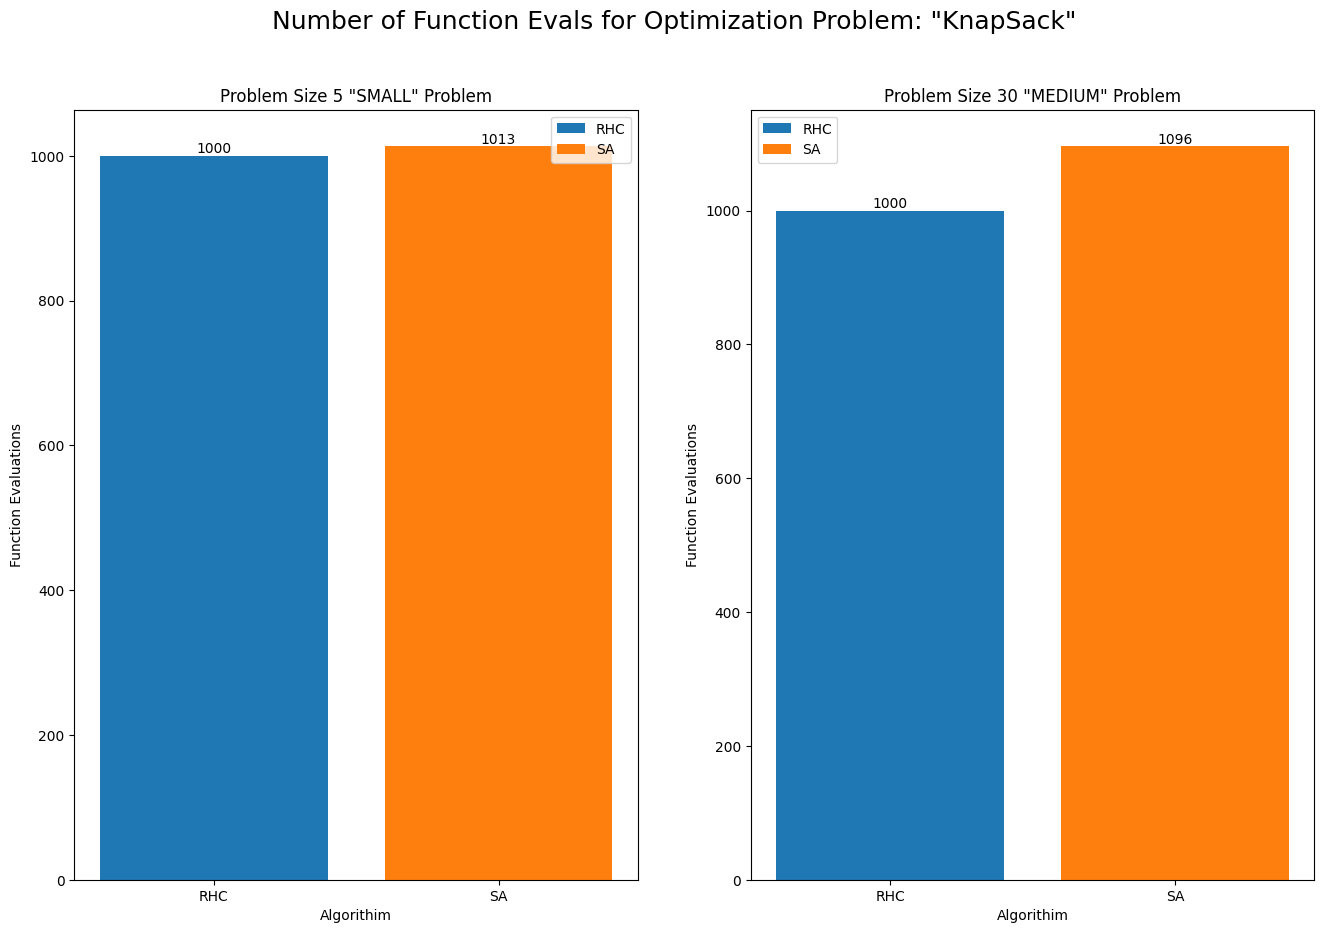

<Figure size 640x480 with 0 Axes>

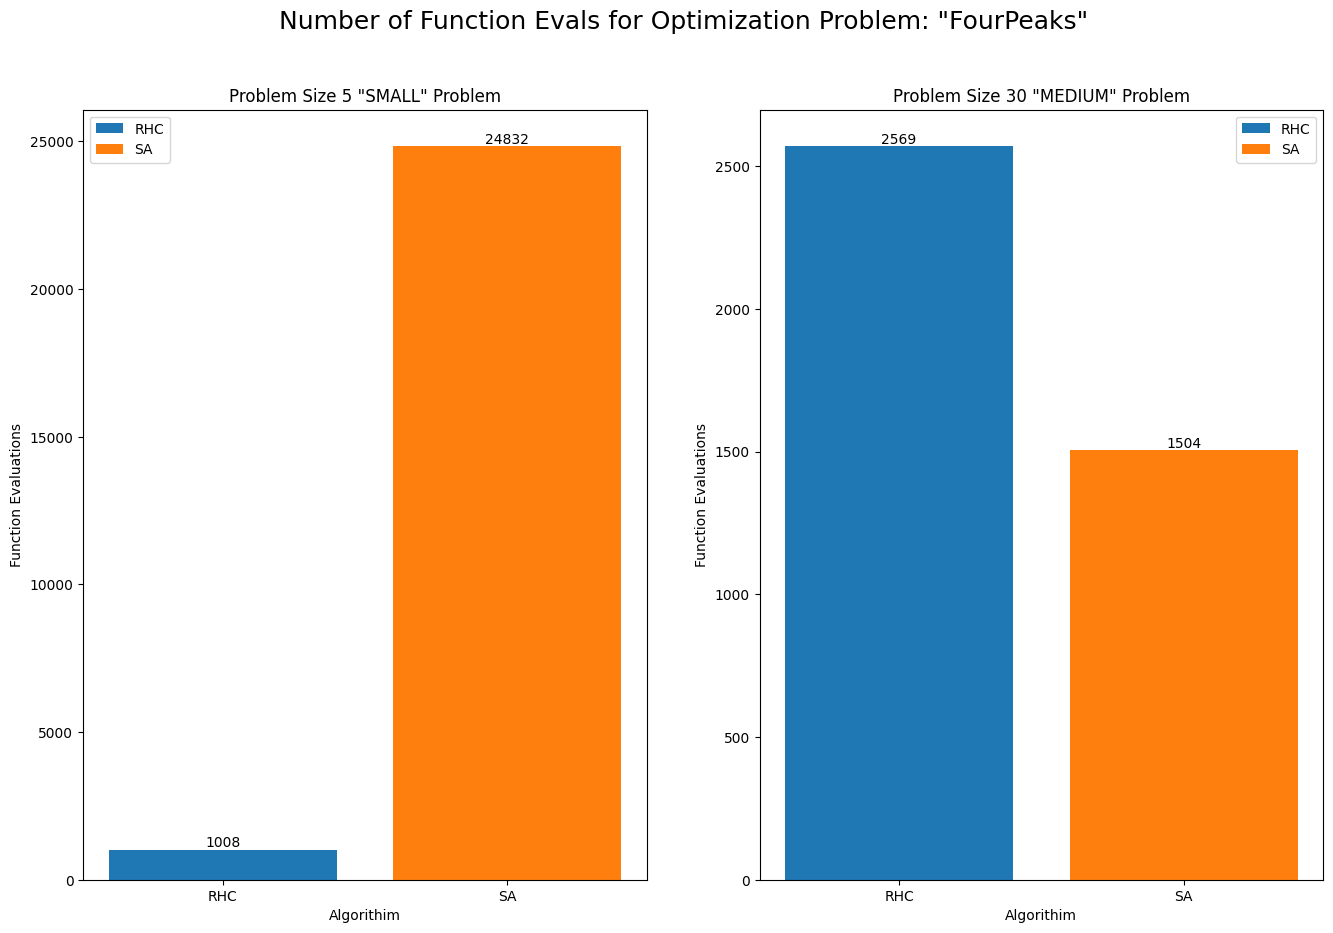

In [219]:

sizes_label={0:'SMALL',1:'MEDIUM',2:'LARGE'}
for problem in OPT_PROBLEMS.keys():

    plt.figure();
    fig,axes=plt.subplots(1,len(size_range))
    fig.set_size_inches(8*len(size_range),10)
    
    plt.suptitle('Number of Function Evals for Optimization Problem: "{}"'.format(problem),fontsize=18)

    for i,size in enumerate(size_range):
        
        axes[i].set_title('Problem Size {} "{}" Problem'.format(size,sizes_label[i]))

        for ii,algorithim in enumerate(ALGORITHIM.keys()):

            axes[i].bar(algorithim,overall_evals[problem][algorithim][size],label=algorithim)
            axes[i].bar_label(axes[i].containers[ii], label_type='edge')

        axes[i].set_ylabel('Function Evaluations');
        axes[i].set_xlabel('Algorithim');
        axes[i].legend();
    plt.show()

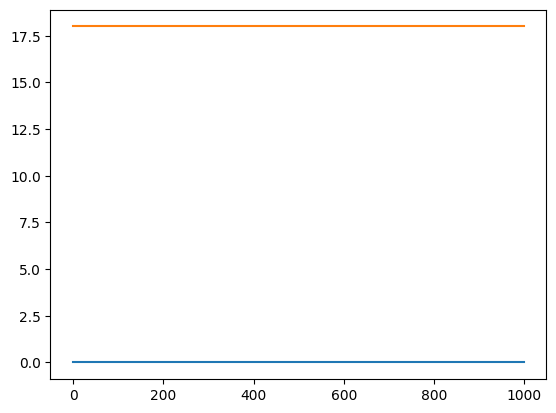

In [187]:
import matplotlib.pyplot as plt
for size in size_range:
for algorithim in ALGORITHIM.keys():
    plt.plot(np.arange(results_dict['overall_iterations']['KnapSack'][algorithim][5].shape[0]),results_dict['overall_iterations']['KnapSack'][algorithim][5][:,0],label=algorithim)

In [103]:
delta={}

In [ ]:
results={'overall_iterations':overall_iterations,'overall_score':overall_score,'overall_time':overall_time,'overall_evals':overall_evals}

In [145]:
#Splitting results into dictionaries

overall_iterations=results_dict['overall_iterations']
overall_score=results_dict['overall_score']
overall_time=results_dict['overall_time']
overall_evals=results_dict['overall_evals']


for problem in OPT_PROBLEMS.keys():

    folder_path='images\Final\{}'.format(problem)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    #Iterations & Fitness Score (With Problem Size) per algorithim per problem
    plt.figure();
    fig,axes=plt.subplots(1,len(ALGORITHIM.keys()))
    fig.set_size_inches(35,10)
    plt.suptitle('Iteartions & Score For Optimization Problem: "{}"'.format(problem),fontsize=18)

    for i,algorithim in enumerate(ALGORITHIM.keys()):
        
        axes[i].set_title('Algorithim : "{}"'.format(algorithim))

        for size in size_range:

            axes[i].plot(np.arange(overall_iterations[problem][algorithim][size].shape[0]),overall_iterations[problem][algorithim][size][:,0],label=str(size))

        axes[i].set_ylabel('Score');
        axes[i].set_xlabel('Iteration');
        axes[i].legend();

    file_path=folder_path+'\iter_score.png'
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

    #Score & Problem Size per algorithim per problem
    plt.figure();
    fig,axes=plt.subplots(1,len(ALGORITHIM.keys()))
    fig.set_size_inches(35,10)
    plt.suptitle('Score & Problem Size : "{}"'.format(problem),fontsize=18)

    for i,algorithim in enumerate(ALGORITHIM.keys()):
        
        axes[i].set_title('Algorithim : "{}"'.format(algorithim))
        axes[i].plot(list(size_range),list(overall_score[problem][algorithim].values()),label='Score & Problem Size')

        axes[i].set_ylabel('Score');
        axes[i].set_xlabel('Problem Size');
        axes[i].legend();

    file_path=folder_path+'\score_size.png'
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

    #Time & Problem Size per algorithim per problem
    plt.figure();
    fig,axes=plt.subplots(1,len(ALGORITHIM.keys()))
    fig.set_size_inches(35,10)
    plt.suptitle('Time & Problem Size : "{}"'.format(problem),fontsize=18)


    for i,algorithim in enumerate(ALGORITHIM.keys()):
        
        axes[i].set_title('Algorithim : "{}"'.format(algorithim))
        axes[i].plot(list(size_range),list(overall_time[problem][algorithim].values()),label='Time & Problem Size')

        axes[i].set_ylabel('Time');
        axes[i].set_xlabel('Problem Size');
        axes[i].legend();

    file_path=folder_path+'\\t_size.png'
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

    #Function Evaluations per alogorithim per problem 

    plt.figure();
    fig,axes=plt.subplots(1,len(ALGORITHIM.keys()))
    fig.set_size_inches(35,10)
    plt.suptitle('Num Function Evals & Problem Size : "{}"'.format(problem),fontsize=18)

    for i,algorithim in enumerate(ALGORITHIM.keys()):
        
        axes[i].set_title('Algorithim : "{}"'.format(algorithim))
        axes[i].plot(list(size_range),list(overall_evals[problem][algorithim].values()),label='Function Evals & Problem Size')

        axes[i].set_ylabel('Num Function Evals');
        axes[i].set_xlabel('Problem Size');
        axes[i].legend();

    file_path=folder_path+'\\feval_size.png'
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

NameError: name 'results_dict' is not defined

In [150]:
length=6
problem=MaxKColorGenerator().generate(seed=42,number_of_nodes=3*length, max_connections_per_node=length, max_colors=length)
high=length-1
init_state=np.random.randint(0,high+1,size=3*length)
mlrose.GA(problem,max_attempts = MAX_ATTEMPTS, max_iters = MAX_ITERATIONS, init_state = init_state, random_state = 42,curve=True)

AttributeError: module 'mlrose_hiive' has no attribute 'GA'

In [89]:
MAX_ATTEMPTS=10000
MAX_ITERATIONS=100


length=6
problem=MaxKColorGenerator().generate(seed=35,number_of_nodes=3*length, max_connections_per_node=length, max_colors=length)
high=length-1
init_state=np.random.randint(0,high+1,size=3*length)
_,_,curve=mlrose.genetic_alg(problem,max_attempts = MAX_ATTEMPTS, max_iters = MAX_ITERATIONS, init_state = init_state, random_state = 10,curve=True)

In [90]:
curve.shape

(100, 2)

In [93]:
curve[-1]

array([    0., 20311.])

In [92]:
curve

array([[2.5000e+01, 4.0200e+02],
       [2.3000e+01, 6.0400e+02],
       [2.0000e+01, 8.0600e+02],
       [1.7000e+01, 1.0080e+03],
       [1.7000e+01, 1.2090e+03],
       [1.7000e+01, 1.4100e+03],
       [1.6000e+01, 1.6120e+03],
       [1.3000e+01, 1.8140e+03],
       [1.3000e+01, 2.0150e+03],
       [1.0000e+01, 2.2170e+03],
       [7.0000e+00, 2.4190e+03],
       [5.0000e+00, 2.6210e+03],
       [2.0000e+00, 2.8230e+03],
       [0.0000e+00, 3.0250e+03],
       [0.0000e+00, 3.2260e+03],
       [0.0000e+00, 3.4270e+03],
       [0.0000e+00, 3.6280e+03],
       [0.0000e+00, 3.8290e+03],
       [0.0000e+00, 4.0300e+03],
       [0.0000e+00, 4.2310e+03],
       [0.0000e+00, 4.4320e+03],
       [0.0000e+00, 4.6330e+03],
       [0.0000e+00, 4.8340e+03],
       [0.0000e+00, 5.0350e+03],
       [0.0000e+00, 5.2360e+03],
       [0.0000e+00, 5.4370e+03],
       [0.0000e+00, 5.6380e+03],
       [0.0000e+00, 5.8390e+03],
       [0.0000e+00, 6.0400e+03],
       [0.0000e+00, 6.2410e+03],
       [0.

In [ ]:
#Function to evaluate all algorithim on a problem
def evaluate_algos(fitness_func,fitness_func_name,only_binary):
    


In [119]:
function_eval(
    fitness_func=mlrose.SixPeaks,
    fitness_func_name='SixPeaks',
    length=6,
    only_binary=False,
    algorithim=mlrose.random_hill_climb,
    algorithim_name='RHC',
    hyperparameter_dict={'restarts':[0,5]})

{'best_score': 1.2,
 'best_iters': 227.0,
 'best_evals': 228.0,
 'best_time': 0.0024005413055419923,
 'best_state': array([0, 0, 0, 0, 0, 0]),
 'final_curve': array([[0.000e+00, 1.000e+00],
        [0.000e+00, 2.000e+00],
        [0.000e+00, 3.000e+00],
        ...,
        [6.000e+00, 1.138e+03],
        [6.000e+00, 1.139e+03],
        [6.000e+00, 1.140e+03]]),
 'best_params': {'restarts': 0}}

In [109]:
function_eval(
    fitness_func=mlrose.Queens,
    fitness_func_name='Queen',
    length=10,
    only_binary=False,
    algorithim=mlrose.simulated_annealing,
    algorithim_name='SA',
    hyperparameter_dict={'schedule':
[GeomDecay(init_temp=0.1),
GeomDecay(init_temp=0.5)]},)

{'best_score': 0.0,
 'best_iters': 1004.0,
 'best_evals': 1045.0,
 'best_time': 0.14412527084350585,
 'best_state': array([6, 1, 3, 5, 8, 4, 9, 0, 2, 7]),
 'final_curve': array([[-7.000e+00,  2.000e+00],
        [-7.000e+00,  4.000e+00],
        [-7.000e+00,  5.000e+00],
        ...,
        [ 0.000e+00,  5.220e+03],
        [ 0.000e+00,  5.221e+03],
        [ 0.000e+00,  5.222e+03]]),
 'best_params': {'schedule': Geo(0.1)}}

In [ ]:
params,results=function_eval(
    fitness_func=mlrose.FlipFlop,
    fitness_func_name='Flip Flop',
    length=3,
    algorithim=mlrose.genetic_alg,
    algorithim_name='GA',
    hyperparameter_dict={
        'pop_size':[100,200]}
        # 'pop_breed_percent':[0.25,0.5],
        # 'mutation_prob':[0.1,0.25]}
    ,graph=True)

In [5]:
params,results=function_eval(
    fitness_func=mlrose.FlipFlop,
    fitness_func_name='Flip Flop',
    length=3,
    algorithim=mlrose.mimic,
    algorithim_name='MIMIC',
    hyperparameter_dict={
        'pop_size':[100,200]}
        # 'pop_breed_percent':[0.25,0.5],
        # 'mutation_prob':[0.1,0.25]}
    ,graph=True)

In [43]:
params

{'pop_size': 100}

In [148]:
length=3
results=function_eval(
    fitness_func=mlrose.Knapsack,
    fitness_func_name='Knapsack',
    length=length,
    only_binary=False,
    algorithim=mlrose.random_hill_climb,
    algorithim_name='RHC',
    hyperparameter_dict={'restarts':np.arange(0,10,2)},
    weights=np.random.randint(1,20,size=length),
    values=np.random.randint(1,20,size=length))

In [31]:
length=3
function_eval(
    fitness_func=mlrose.Knapsack,
    fitness_func_name='Knapsack',
    length=length,
    only_binary=False,
    algorithim=mlrose.mimic,
    algorithim_name='MIMIC',
    hyperparameter_dict={
        'pop_size':[100,200]},
    weights=np.random.randint(1,20,size=length),
    values=np.random.randint(1,20,size=length))

({'pop_size': 100},
 {'best_score': 24.0,
  'best_iters': 1001.0,
  'best_evals': 101202.0,
  'best_time': 3.0372256278991703,
  'best_state': array([0, 0, 2])})

In [143]:
test=MaxKColorGenerator().generate(seed=123456, number_of_nodes=18, max_connections_per_node=4, max_colors=4)

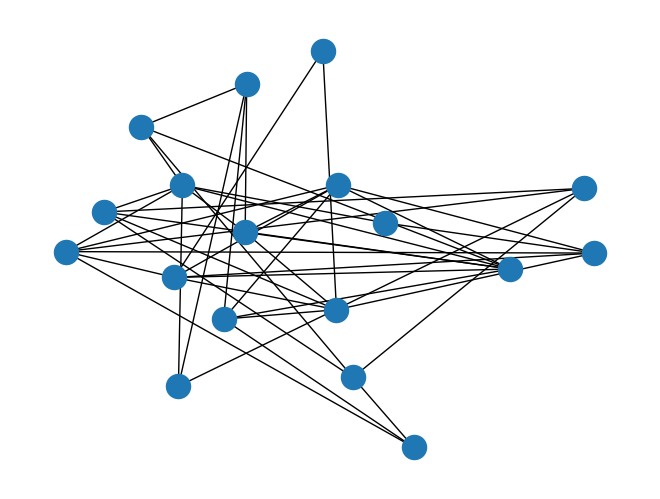

In [144]:
nx.draw(test.source_graph,
        pos=nx.spring_layout(problem.source_graph, seed = 3))
plt.show()

In [36]:
#Reading Dict
file_path='p1/results_dict.json'
with open(file_path, 'r') as fp:
    data = json.load(fp)

In [37]:
data

'[{},{},{},{}]'

In [50]:
t1=np.array([[1,2,3,4],[1,2,3,4]])
t2=np.array([[1,2,3],[1,2,3]])

In [46]:
np.mean(np.array([t1,t2]),axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

In [63]:
np.pad(t2,pad_width=(0,1),mode='edge')

array([[1, 2, 3, 3],
       [1, 2, 3, 3],
       [1, 2, 3, 3]])

In [66]:
t1=np.array([[1,2],[2,3],[3,5]])
t2=np.array([[1,3],[3,1]])

In [78]:
final_curves=[]
final_curves.append(t1[:,0])
final_curves.append(t2[:,0])

In [81]:
final_curves

[array([1, 2, 3]), array([1, 2])]

In [88]:
max_size=0
for ar in final_curves:
    if ar.shape[0]>max_size:
        max_size=ar.shape[0]

new_final_curves=[]
for ar in final_curves:
    new_final_curves.append(np.pad(ar,pad_width=(0,max_size-ar.shape[0]),mode='edge'))

In [92]:
np.mean(np.array(new_final_curves),axis=0)

array([1. , 2. , 2.5])

In [11]:
from mlrose_hiive import RHCRunner, SARunner, GARunner, MIMICRunner, QueensGenerator, FlipFlopGenerator, MaxKColorGenerator, FourPeaks, GeomDecay,ExpDecay
import matplotlib.pyplot as plt
Geom=[GeomDecay(10),GeomDecay(50),GeomDecay(100)]
EXP=[ExpDecay(10),ExpDecay(50),ExpDecay(100)]


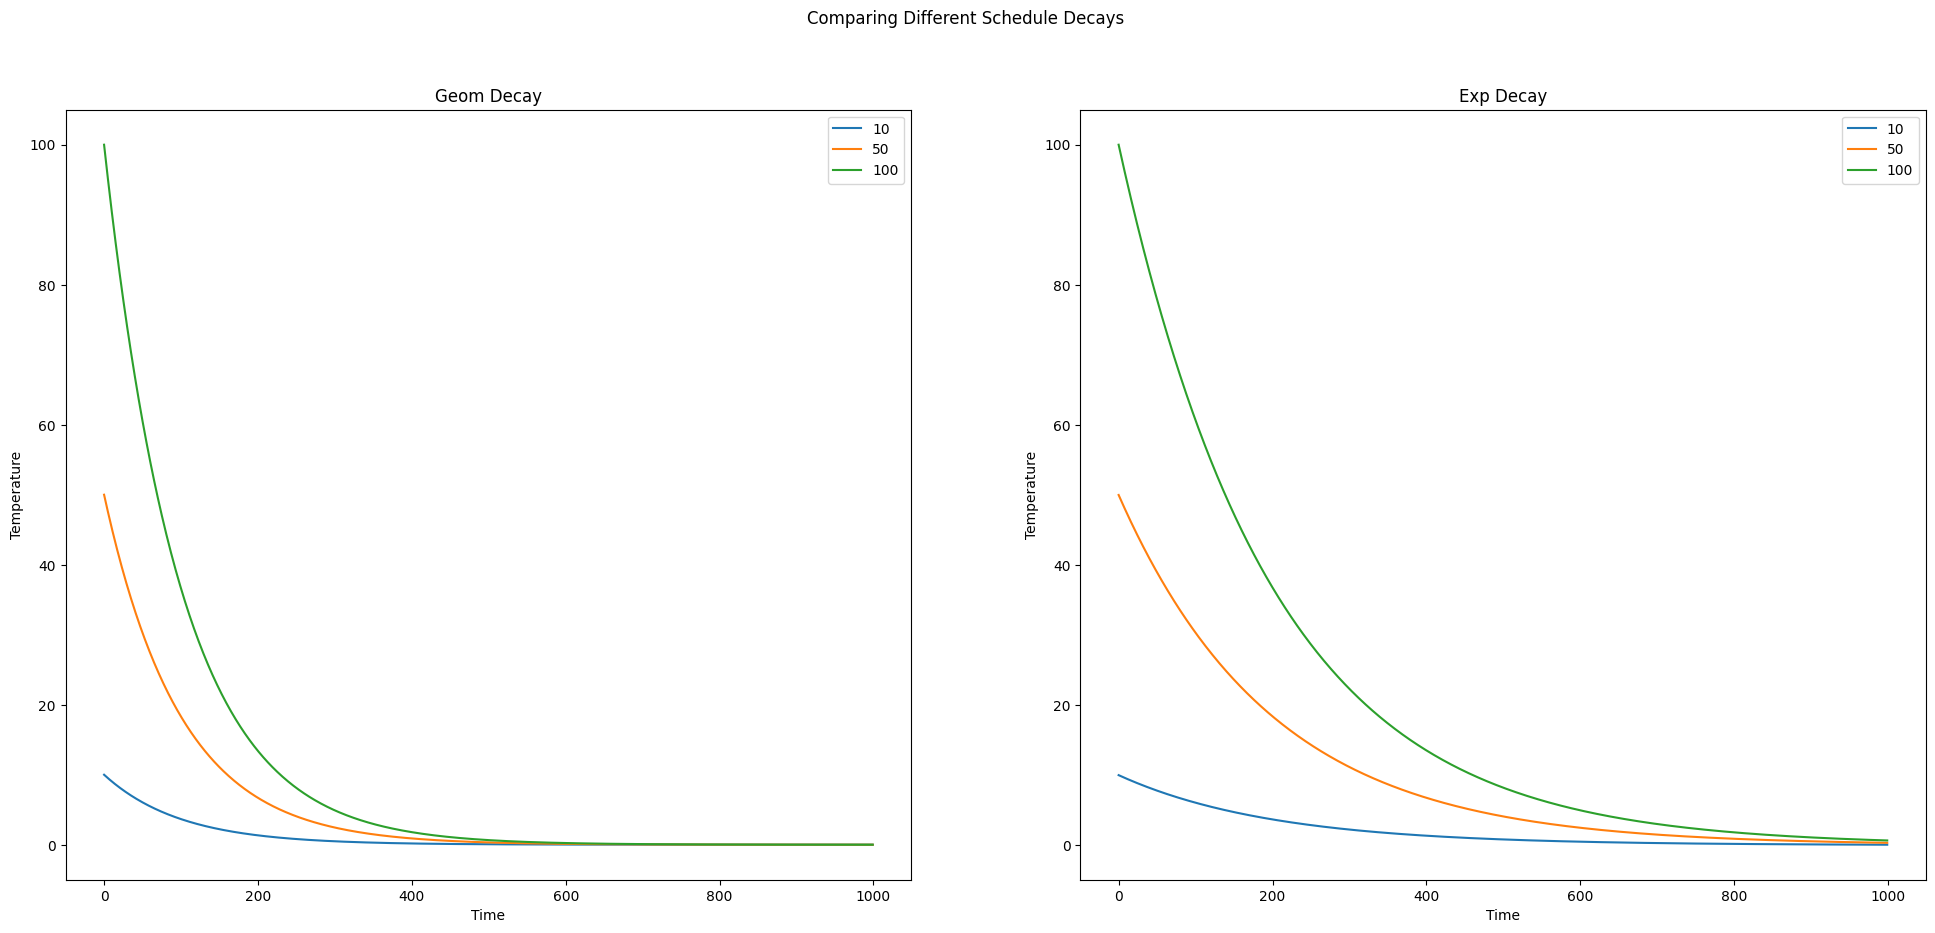

In [22]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(8*3,10)

T=1000
plt.suptitle('Comparing Different Schedule Decays')
for g in Geom:
    vals=[]
    for t in range(T):
        vals.append(g.evaluate(t))

    axes[0].plot(list(range(T)),vals,label=g)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Temperature')
    axes[0].set_title('Geom Decay')
    axes[0].legend()

for e in EXP:
    vals=[]
    for t in range(T):
        vals.append(e.evaluate(t))

    axes[1].plot(list(range(T)),vals,label=e)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Temperature')
    axes[1].set_title('Exp Decay')
    axes[1].legend()

In [253]:
from PIL import Image
import numpy as np

img1=Image.open("Report Images/RHC_COMB/Feval_loss.png")
img2=Image.open("Report Images/RHC_COMB/iter_Loss.png")
img3=Image.open("Report Images/RHC_COMB/LR_2.png")
img4=Image.open("Report Images/RHC_COMB/LRC.png")
img5=Image.open("Report Images/RHC_COMB/Restarts.png")

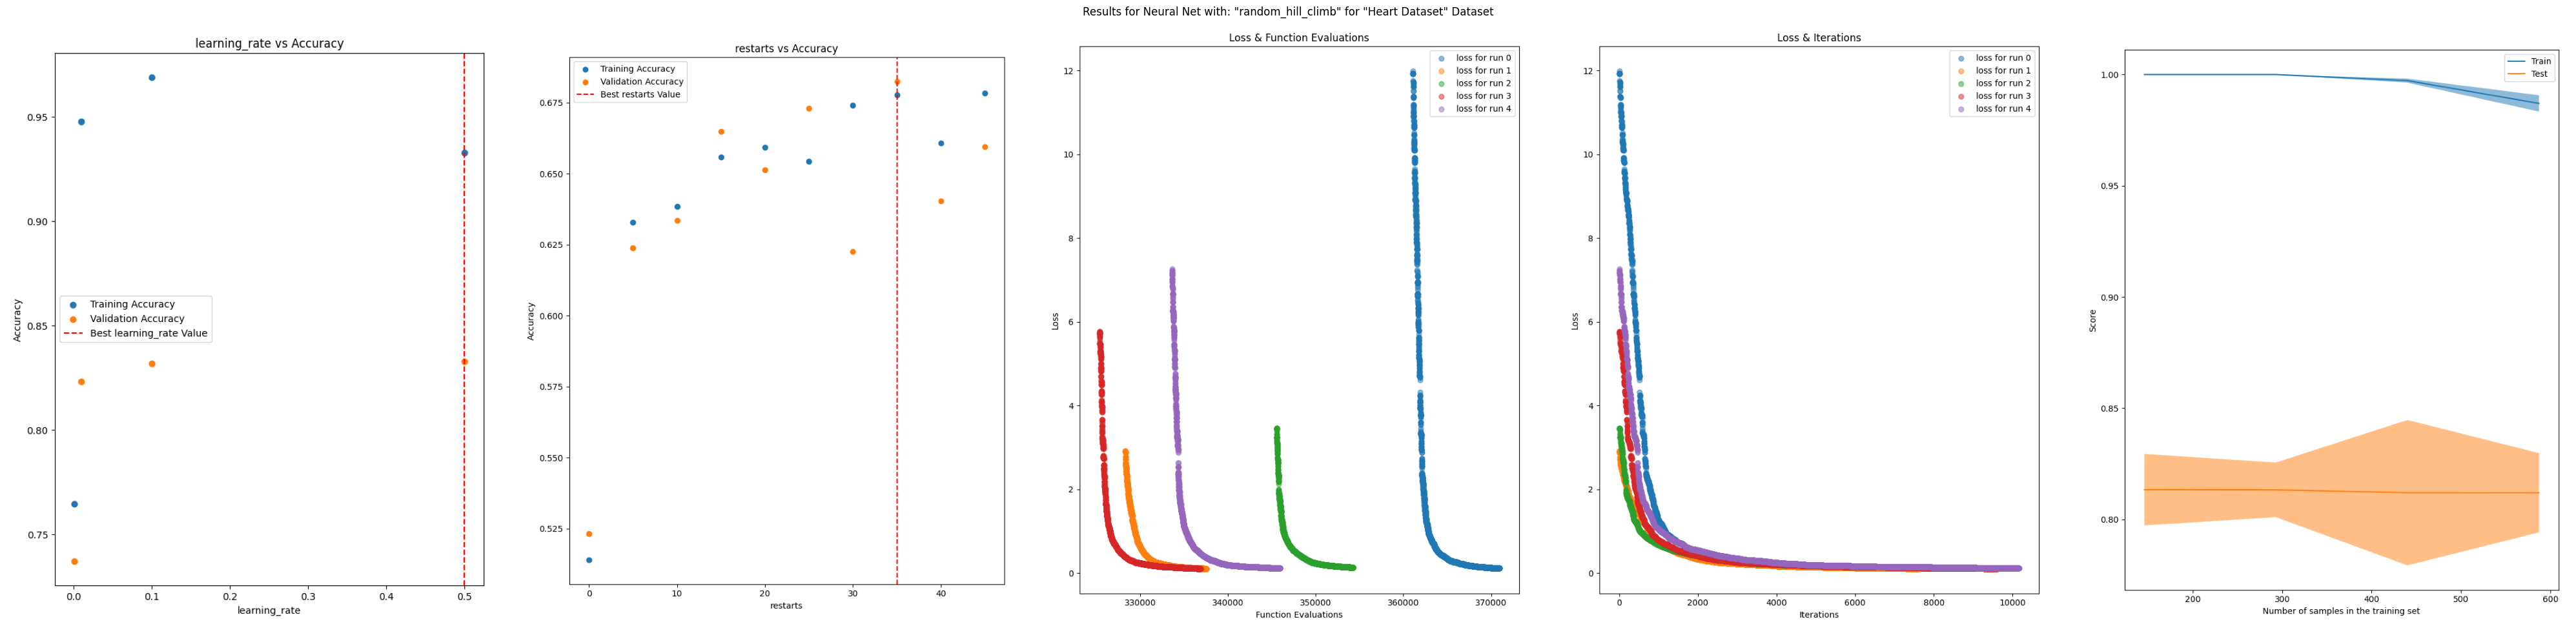

In [254]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5)
fig.set_size_inches(8*5, 10)

plt.suptitle('Results for Neural Net with: "random_hill_climb" for "Heart Dataset" Dataset')

axes[0].imshow(img3)
axes[0].axis('off')

axes[1].imshow(img5)
axes[1].axis('off')

axes[2].imshow(img1)
axes[2].axis('off')

axes[3].imshow(img2)
axes[3].axis('off')

axes[4].imshow(img4)
axes[4].axis('off')

# Get the current position of the first subplot
current_position = axes[0].get_position()

# Define the new width for the subplot
new_width = current_position.width * 1.15

# Keep the height unchanged
new_height = current_position.height

# Set the new position for the first subplot
axes[0].set_position([current_position.x0, current_position.y0 + 0.05, new_width, new_height])

plt.tight_layout()
plt.show()

In [126]:
problem=MaxKColorGenerator().generate(seed=3,number_of_nodes=5,max_connections_per_node=10,max_colors=3)

In [131]:
problem.fitness_fn.evaluate([1,0,2,2,1])

-2

In [127]:
problem.fitness_fn.edges

[(0, 1),
 (2, 4),
 (1, 2),
 (0, 4),
 (3, 4),
 (0, 3),
 (1, 4),
 (2, 3),
 (0, 2),
 (1, 3)]

In [143]:
learning_rate=[0.5,0.1,0.01,0.001]
train_acc=[0.93256,0.968878,0.94755,0.7643225]
test_acc=[0.8324690,0.83153395,0.82291736,0.7370636779]

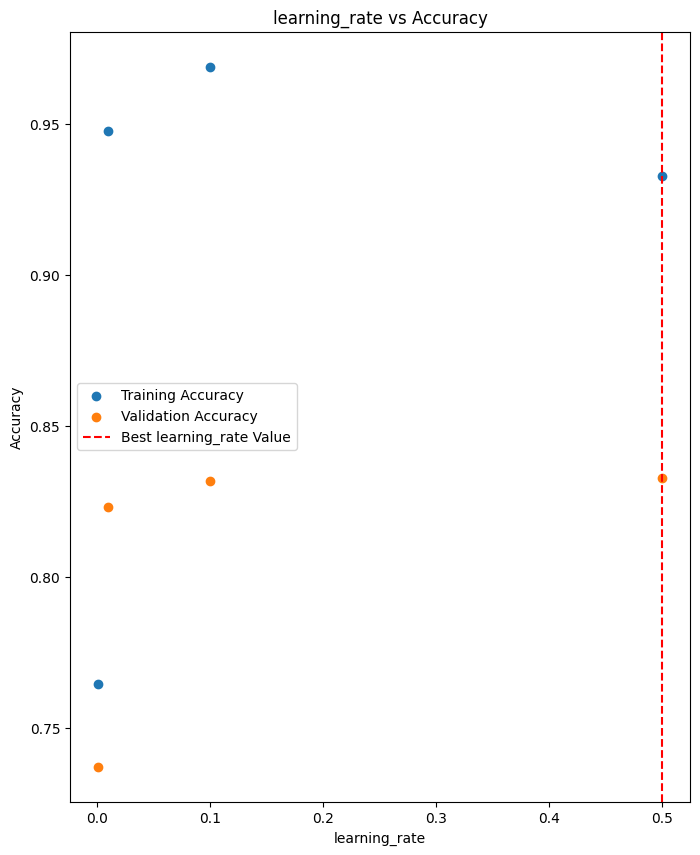

In [224]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))

metric_name = 'Accuracy'
param = 'learning_rate'

ax.scatter(learning_rate, train_acc, label='Training {}'.format(metric_name))
ax.scatter(learning_rate, test_acc, label='Validation {}'.format(metric_name))
ax.axvline(0.5, label='Best {} Value'.format(param), color='red', linestyle='--')

ax.set_title('{} vs {}'.format(param, metric_name))
ax.legend()
ax.set_ylabel('{}'.format(metric_name))
ax.set_xlabel(param)

plt.show()

In [255]:
#Final scores
labels=['Gradient Descent','Random Hill Climbing','Simulated Anllealing','Genetic Algorithm']
train_accuracy=[1,0.945,0.93515,0.847684]
test_accuracy=[0.861413,0.8402,0.8,0.813043]
training_time=[70.05046,795.853,215.087,33.53612]

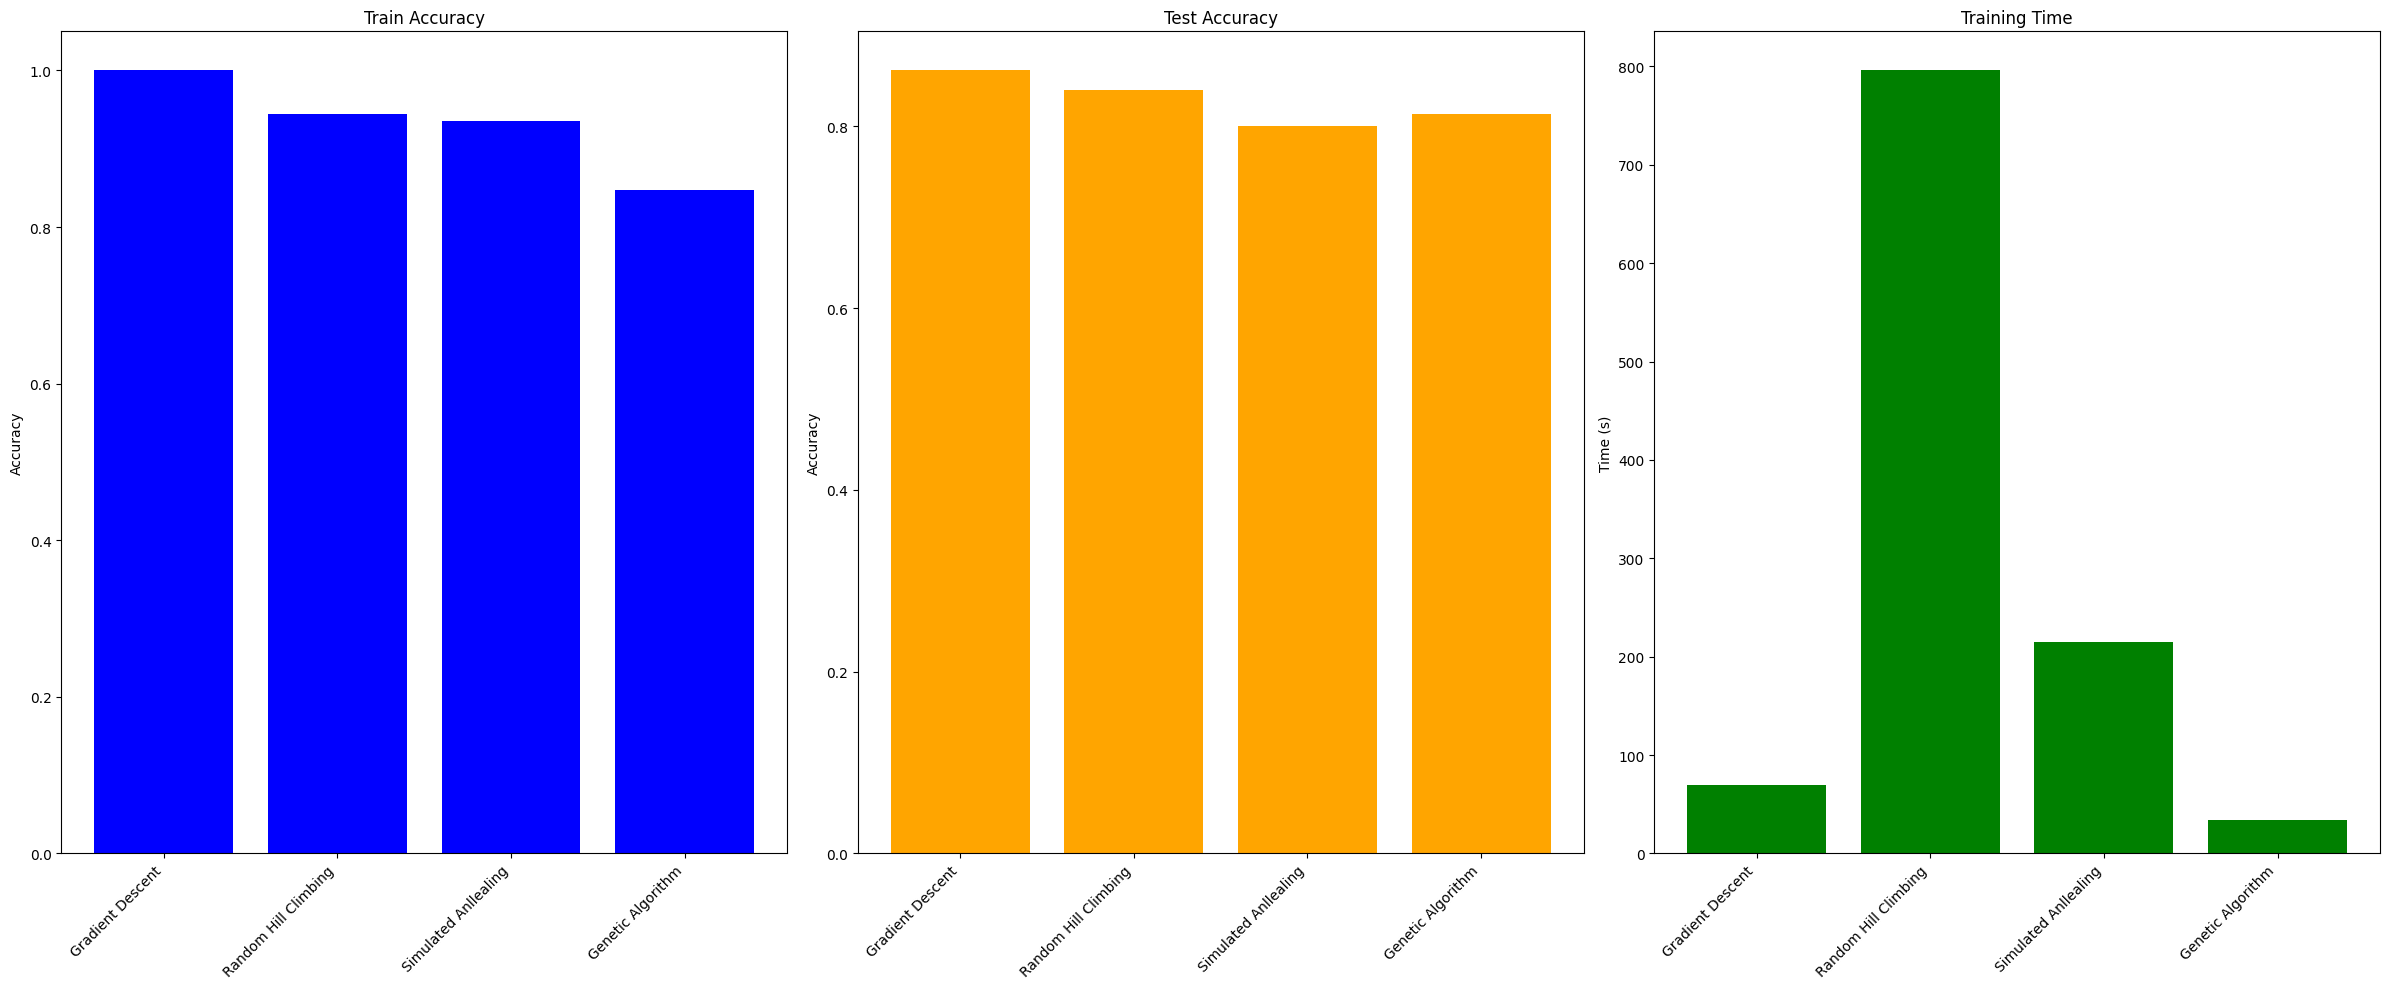

In [256]:
#Final plots 
fig, axs = plt.subplots(1,3)
fig.set_size_inches(24,10)


# Plot train accuracy
axs[0].bar(labels, train_accuracy, color='b')
axs[0].set_title('Train Accuracy')
axs[0].set_ylabel('Accuracy')

# Plot test accuracy
axs[1].bar(labels, test_accuracy, color='orange')
axs[1].set_title('Test Accuracy')
axs[1].set_ylabel('Accuracy')

# Plot training time
axs[2].bar(labels, training_time, color='g')
axs[2].set_title('Training Time')
axs[2].set_ylabel('Time (s)')

# Rotate x labels
for ax in axs:
    ax.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()